In [2]:
# Needed libraries 
# Reference Material - https://medium.com/geekculture/bayesian-time-series-forecasting-c8e1928d34d4

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from pybats.analysis import analysis
from pybats.point_forecast import median
from pybats.plot import plot_data_forecast
from pybats.loss_functions import MSE

import numpy as np

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Making the plots standard 
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 5]

In [3]:
df = pd.read_pickle('df_timeseries.pickle')

In [4]:
# Create the dataframe for the forecast
df_bats = df.copy()
df_bats.groupby(['nprb_id','dst_addr'])

#Extracting the results of one probe and destination
df_bats = df_bats[(df_bats['nprb_id'] == 'es1') & (df_bats['dst_addr'] == "52.46.200.93")]

In [5]:
# Extracting the results column in order to process the avg rtt
df_rtt = df_bats.result.apply(pd.Series).set_axis(['ping_one','ping_two','ping_three',3,4,5],axis=1) #https://stackoverflow.com/questions/70584804/how-to-extract-list-of-dictionaries-from-pandas-column
df_rtt = df_rtt.dropna(axis=1)

#https://stackoverflow.com/questions/35711059/extract-dictionary-value-from-column-in-data-frame?noredirect=1&lq=1
df_rtt['ping_one_Value'] = df_rtt['ping_one'].apply(lambda x: x.get('rtt'))
df_rtt['ping_two_Value'] = df_rtt['ping_two'].apply(lambda x: x.get('rtt'))
df_rtt['ping_three_Value'] = df_rtt['ping_three'].apply(lambda x: x.get('rtt'))

#getting the average of the ping values 
df_rtt['avg_rtt_result'] = df_rtt[['ping_one_Value','ping_two_Value','ping_three_Value']].mean(axis=1)
df_rtt

,ping_one,ping_two,ping_three,ping_one_Value,ping_two_Value,ping_three_Value,avg_rtt_result
22549,{'rtt': 51.698169},{'rtt': 51.756525},{'rtt': 51.723537},51.698169,51.756525,51.723537,51.726077
22559,{'rtt': 50.993586},{'rtt': 50.971157},{'rtt': 51.112259},50.993586,50.971157,51.112259,51.025667
22569,{'rtt': 51.715804},{'rtt': 51.724153},{'rtt': 51.679314},51.715804,51.724153,51.679314,51.706424
22579,{'rtt': 51.063621},{'rtt': 51.03592},{'rtt': 51.056587},51.063621,51.035920,51.056587,51.052043
22589,{'rtt': 51.104533},{'rtt': 51.177799},{'rtt': 51.017722},51.104533,51.177799,51.017722,51.100018
...,...,...,...,...,...,...,...
28134,{'rtt': 54.721446},{'rtt': 54.704551},{'rtt': 54.813593},54.721446,54.704551,54.813593,54.746530
28144,{'rtt': 54.766741},{'rtt': 54.754952},{'rtt': 54.855641},54.766741,54.754952,54.855641,54.792445
28154,{'rtt': 54.694568},{'rtt': 54.759688},{'rtt': 54.732717},54.694568,54.759688,54.732717,54.728991
28164,{'rtt': 48.771845},{'rtt': 48.712132},{'rtt': 48.650611},48.771845,48.712132,48.650611,48.711529


In [6]:
#adding the avg-rtt from the three pings to the original dataframe 
df_bats =  pd.concat([df_bats,df_rtt],axis = 1)
df_bats = df_bats.set_index(df_bats['new_time'])
df_bats

,fw,mver,lts,dst_name,af,dst_addr,src_addr,proto,ttl,size,...,stored_timestamp,nprb_id,new_time,ping_one,ping_two,ping_three,ping_one_Value,ping_two_Value,ping_three_Value,avg_rtt_result
new_time,,,,,,,,,,,,,,,,,,,,,
2023-01-16 11:17:39,5080,2.6.2,43,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1673864259,es1,2023-01-16 11:17:39,{'rtt': 51.698169},{'rtt': 51.756525},{'rtt': 51.723537},51.698169,51.756525,51.723537,51.726077
2023-01-16 11:21:58,5080,2.6.2,49,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1673864518,es1,2023-01-16 11:21:58,{'rtt': 50.993586},{'rtt': 50.971157},{'rtt': 51.112259},50.993586,50.971157,51.112259,51.025667
2023-01-16 11:26:54,5080,2.6.2,39,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1673864814,es1,2023-01-16 11:26:54,{'rtt': 51.715804},{'rtt': 51.724153},{'rtt': 51.679314},51.715804,51.724153,51.679314,51.706424
2023-01-16 11:31:52,5080,2.6.2,48,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1673865112,es1,2023-01-16 11:31:52,{'rtt': 51.063621},{'rtt': 51.03592},{'rtt': 51.056587},51.063621,51.035920,51.056587,51.052043
2023-01-16 11:37:02,5080,2.6.2,0,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1673865422,es1,2023-01-16 11:37:02,{'rtt': 51.104533},{'rtt': 51.177799},{'rtt': 51.017722},51.104533,51.177799,51.017722,51.100018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-18 09:52:02,5080,2.6.2,42,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1674031922,es1,2023-01-18 09:52:02,{'rtt': 54.721446},{'rtt': 54.704551},{'rtt': 54.813593},54.721446,54.704551,54.813593,54.746530
2023-01-18 09:56:43,5080,2.6.2,43,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1674032203,es1,2023-01-18 09:56:43,{'rtt': 54.766741},{'rtt': 54.754952},{'rtt': 54.855641},54.766741,54.754952,54.855641,54.792445
2023-01-18 10:01:51,5080,2.6.2,35,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1674032511,es1,2023-01-18 10:01:51,{'rtt': 54.694568},{'rtt': 54.759688},{'rtt': 54.732717},54.694568,54.759688,54.732717,54.728991


In [7]:
# Define PyBATS analysis object

Y  = df_bats['avg'].values
rho = 0.5  # discount factor for prior
forecast_horizon = 0  # forecast horizon is 0 for in-sample forecasts
ar_order = 1  # order of the AR model
forecast_start = pd.to_datetime('2023-01-16 11:17:39') # starting forecast at time step 0
forecast_end =pd.to_datetime('2023-01-18 10:12:57') # ending forecast at the same time our data ends



mod, samples = analysis(
                                    Y,
                                    k=ar_order, # Forecast horizon. If k>1, default is to forecast 1:k steps ahead, marginally
                                    forecast_start=forecast_start, # First time step to forecast on
                                    forecast_end=forecast_end,# Final time step to forecast on
                                    family = 'normal', # model continuous real numbers with normally distributed observation errors.
                                    ntrend = 2, # Use an intercept and local slope
                                    model_prior = None, 
                                    dates = df_bats.new_time, 
                                    rho = .5,
                                    ret=['model', 'forecast'],
                                    mean_only = False, 
                                    forecast_path = False,
)


# Generate in-sample forecasts
forecast = median(samples)

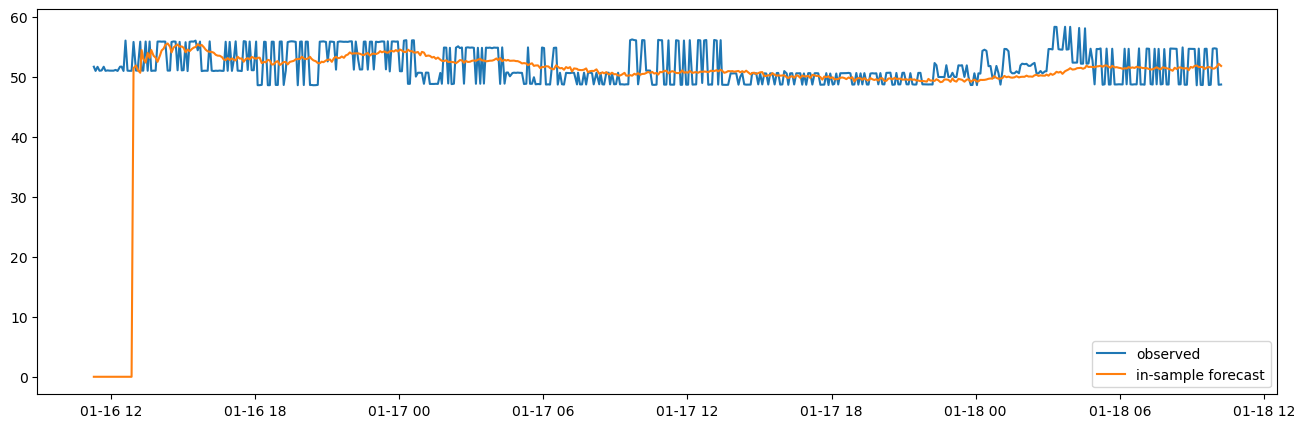

In [8]:
# Plot the results
plt.plot(df_bats.index, Y, label='observed')
plt.plot(df_bats.index, forecast, label='in-sample forecast')
plt.legend()
plt.show()

In [8]:
forecast_values = samples
forecast_values.shape

(500, 564, 1)